In [ ]:
import pandas as pd
#data collection
df = pd.read_csv('dataset_phishing.csv')

df.head()

#data pre-processing
if 'url' in df.columns:
    df.drop(columns='url',inplace=True)

df['status'] = df['status'].map({'phishing':1, 'legitimate':0})

df_clean = df.dropna()

df_clean.to_csv("phishing_data.csv",index=False)

df_clean.head()


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0


status                1.000000
google_index          0.731171
ratio_digits_url      0.356395
domain_in_title       0.342807
phish_hints           0.335393
ip                    0.321698
nb_qm                 0.294319
length_url            0.248580
nb_slash              0.242270
length_hostname       0.238322
nb_eq                 0.233386
ratio_digits_host     0.224335
shortest_word_host    0.223084
prefix_suffix         0.214681
longest_word_path     0.212709
tld_in_subdomain      0.208884
empty_title           0.207043
nb_dots               0.207029
longest_words_raw     0.200147
avg_word_path         0.197256
Name: status, dtype: float64
nb_hyphens                   -0.100107
ratio_extMedia               -0.140406
external_favicon             -0.146565
ratio_extRedirection         -0.150827
domain_registration_length   -0.161719
domain_with_copyright        -0.173098
safe_anchor                  -0.173397
links_in_tags                -0.184401
ratio_intMedia               -0.193333


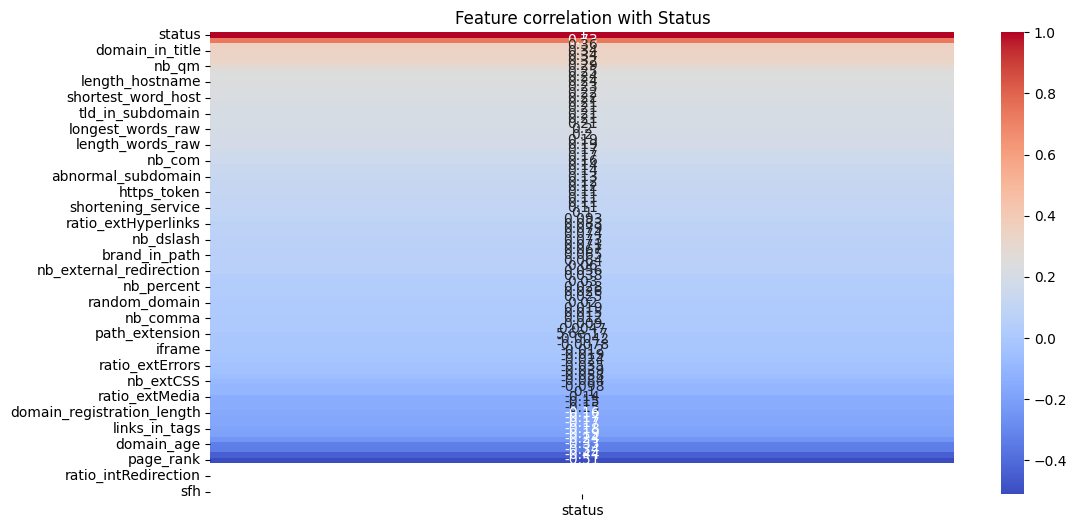

In [ ]:
#finding correlation as in how the status is correlated with other features
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr(numeric_only=True)

target_corr = corr['status'].sort_values(ascending=False)
print(target_corr.head(20))
print(target_corr.tail(20))

# Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(corr[['status']].sort_values(by='status', ascending=False), annot=True, cmap="coolwarm")
plt.title("Feature correlation with Status")
plt.show()


google_index            0.169744
page_rank               0.100367
nb_hyperlinks           0.087397
web_traffic             0.073052
domain_age              0.038080
nb_www                  0.037966
phish_hints             0.029911
ratio_intHyperlinks     0.028965
longest_word_path       0.026592
safe_anchor             0.023949
ratio_extHyperlinks     0.023629
ratio_digits_url        0.019259
ratio_extRedirection    0.018042
length_url              0.016660
avg_word_path           0.015603
longest_words_raw       0.015139
length_words_raw        0.014894
shortest_word_host      0.014563
length_hostname         0.014563
char_repeat             0.014384
dtype: float64


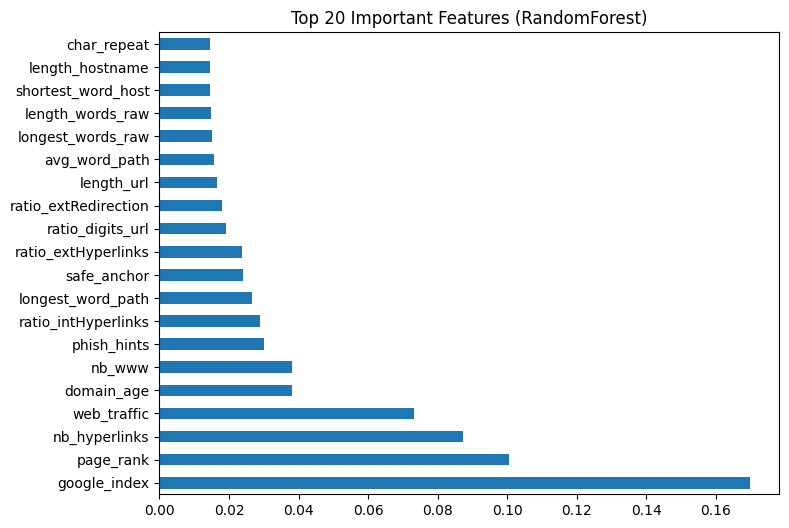

In [ ]:
# Feature Importance using RandomForest
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['status'])
y = df['status']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)
print(top_features)

# Plot
top_features.plot(kind='barh', figsize=(8,6))
plt.title("Top 20 Important Features (RandomForest)")
plt.show()

In [ ]:
import re, json, joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("phishing_data.csv", low_memory=False)
if 'status' not in df.columns:
    raise SystemExit("Label column 'status' not found in CSV")

y = df['status'].astype(int)
X_all = df.drop(columns=['status']).copy()

In [ ]:
#Importance checking by Random Forest
X_all_num = X_all.apply(pd.to_numeric, errors='coerce').fillna(0.0)
rf_full = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
print("Training quick RF to get importances (this uses all existing features)...")
rf_full.fit(X_all_num, y)

importances = pd.Series(rf_full.feature_importances_, index=X_all_num.columns).sort_values(ascending=False)
print("Top 15 features by importance (full-model):")
print(importances.head(15))

In [ ]:
# Heuristic: pick features whose column name matches typical URL-feature patterns
url_feature_pattern = re.compile(
    r'(length_|nb_|ip$|punycode|www|com|http_in_path|https_token|ratio_digits|subdomain|shorten|prefix_suffix|random_domain|tld_|hostname|host|dots|hyphens|slash|qm|and|at)',
    flags=re.I
)

# filter importances list to those matching the regex
url_derived_candidates = [c for c in importances.index if url_feature_pattern.search(c)]
print(f"Found {len(url_derived_candidates)} URL-derived candidate features (examples): {url_derived_candidates[:15]}")


In [ ]:
TOP_N = 12
selected = [c for c in importances.index if c in url_derived_candidates][:TOP_N]
print("Selected features for robust model:", selected)

In [ ]:
#Preparing
X = X_all[selected].apply(pd.to_numeric, errors='coerce')
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

In [ ]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
#Predict
pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print("Classification report:\n", classification_report(y_test, pred, zero_division=0))

In [ ]:
#Cross Validation
cv_scores = cross_val_score(rf, X_imp, y, cv=5, scoring='accuracy', n_jobs=-1)
print("5-fold CV accuracy mean:", cv_scores.mean())

In [ ]:
#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

#Heatmap
y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Phishing or Not Phishing')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#BarGraph
actual_counts = pd.Series(y_test).value_counts().sort_index()
predicted_counts = pd.Series(y_pred).value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
})
comparison_df.index = ['Legitimate', 'Phishing']

comparison_df.plot(kind='bar', figsize=(7, 4), color=['skyblue', 'salmon'])
plt.title('Phishing or Not Phishing')
plt.ylabel('Number of Websites')
plt.xlabel('Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [ ]:
model_path = "robust_rf.pkl"
meta_path = "robust_meta.json"
joblib.dump(rf, model_path)
meta = {
    "features": X.columns.tolist(),
    "medians": dict(zip(X.columns, imp.statistics_.tolist()))
}
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)
print(f"Saved model -> {model_path}")
print(f"Saved metadata -> {meta_path}")